In [71]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, balanced_accuracy_score, f1_score

# Loading the data

In [186]:
path_digit = "../Session 1/digits.npz"
path_pima = "./pima.npz"

with np.load(path_digit) as digits_data:
    # img = (digits_data['x'] / 255).reshape(3000, 28 ,28)
    # img_train = (digits_data['xt'] / 255).reshape(1500, 28 ,28)
    img = (digits_data['x'] / 255)
    img_train = (digits_data['xt'] / 255)
    img_label = digits_data['y']
    img_train_label = digits_data['yt']
    
with np.load(path_pima) as pima_data:
#     print(pima_data.files)
    xall = pima_data['xall']
    yall = pima_data['yall']
    varnames = pima_data['varnames']

In [3]:
# compute statistics
pima_df = pd.DataFrame(xall, columns=varnames)
pima_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000
mean,3.747532,121.607898,69.643159,20.765867,80.531735,32.453032,0.470961,33.021157
std,3.339502,30.490598,18.135582,15.899540,112.678399,6.950733,0.325256,11.669089
min,0.000000,44.000000,0.000000,0.000000,0.000000,18.200000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.500000,0.243000,24.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.374000,29.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.600000,0.629000,40.000000
max,17.000000,199.000000,122.000000,99.000000,744.000000,67.100000,2.420000,81.000000


First, we look at the statistics of the variables. 

- Pregnancies: The mean number of pregnancies is 3.75 . The minimum is 0 (the minimum age is 21 years, logical); the others quartiles also seems normal. But the maximum is 17 times, which seems a little big (potential outlier).
- Glucose, BMI, DiabetesPedigreeFunction: Mean and the quartiles seem reasonable.
- BloodPressure: The minimum seems being an outlier.
- SkinThickness, Insulin: same as BloodPressure, strange when we look at minimum and first quartile. Probably, there are missing data on those samples.
- Age: average age is 33 years old. The samples are relatively young. Need to pay attention to the maximum (81 years old).

In [4]:
def plots(imgs, interp=False):
    imgs=np.array(imgs)
    mn,mx=imgs.min(),imgs.max()
    f = plt.figure(figsize=(12,24))
    for i in range(len(imgs)):
        sp=f.add_subplot(1, len(imgs), i+1)
        plt.axis('off')
        plt.imshow(imgs[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)

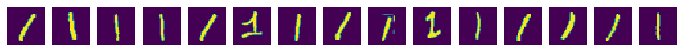

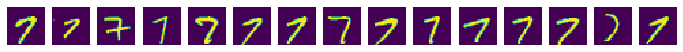

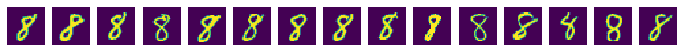

In [5]:
n_samples_per_class = int(img.shape[0] / 3)
n_sample_to_show = 15

plots(img[:15,:,:])
plots(img[n_samples_per_class:n_samples_per_class+n_sample_to_show,:,:])
plots(img[n_samples_per_class*2:n_samples_per_class*2+n_sample_to_show,:,:])

# Predicting Diabetes on the Pima dataset

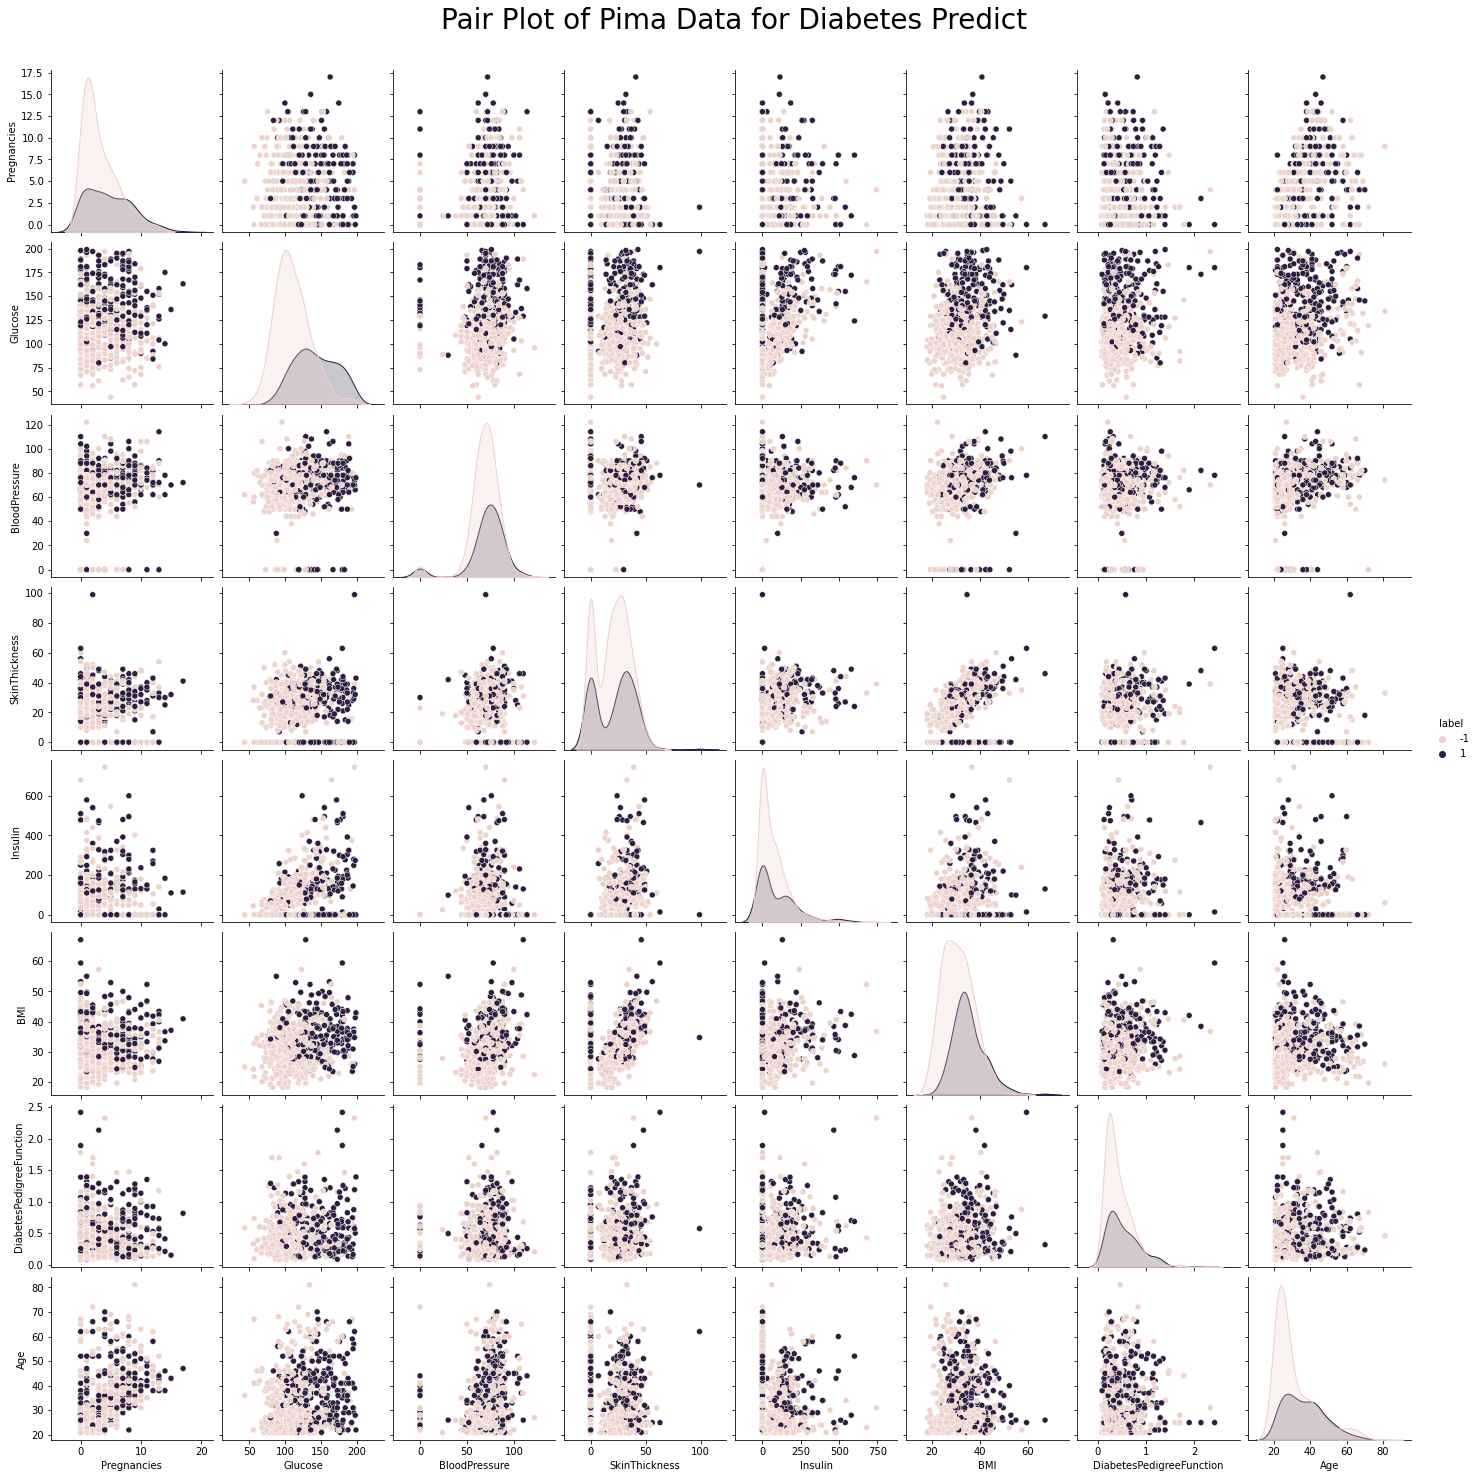

In [6]:
pima_df['label'] = yall
sns.pairplot(pima_df, hue='label')
plt.suptitle('Pair Plot of Pima Data for Diabetes Predict', 
             size = 28, y = 1.03)
plt.show()

Looking at the histogram of uni-variate, the ditribution of two classes in `BMI` and in `Glucose` are different (different position of picks for example). The pairplot between them is also discriminatory for two classes.

Therefore, these two variables seems to be good variables for prediction. Meanwhile, `BMI` and `Glucose` are strongly related to the diabetes. It does make sense to analyse them, from a medical perspective.

## Split data (non shuffle)

In [7]:
# pima_train_x, pima_test_x, pima_train_y, pima_test_y  = train_test_split(xall, yall, train_size=300, shuffle=True)
TrainSize = 300

pima_train_x = xall[:TrainSize, ]
pima_test_x = xall[TrainSize:, ]
pima_train_y = yall[:TrainSize]
pima_test_y = yall[TrainSize:]

## Standard Scaler

The variance of variable `Glucose` is 30.5; but for `BMI`, the variance is 7.0

It could be a problem when we apply a linear model (the scale of parameters before these two variables could be largely different, which is not good for robustness of model)

As a result, it would be better to perform a standarization as a preprocessing.

In [8]:
scaler = StandardScaler()
pima_train_x = scaler.fit_transform(pima_train_x)
pima_test_x = scaler.transform(pima_test_x)

# Bayesian decision and linear classification

### LDA

In [9]:
lda = LinearDiscriminantAnalysis()
lda.fit(pima_train_x, pima_train_y)

print(f"The accuracy on test data is {lda.score(pima_test_x, pima_test_y)}")
print(f"The AUC score on test data is {roc_auc_score(pima_test_y, lda.predict_proba(pima_test_x)[:, 1])}")

The accuracy on test data is 0.7946210268948656
The AUC score on test data is 0.8636637129416913


In [10]:
parameters = {'shrinkage': np.linspace(0, 1, 50)}
grid_search = GridSearchCV(LinearDiscriminantAnalysis(solver='eigen'), parameters, scoring='roc_auc')
grid_search.fit(pima_train_x, pima_train_y)

GridSearchCV(estimator=LinearDiscriminantAnalysis(solver='eigen'),
             param_grid={'shrinkage': array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])},
             scoring='roc_auc')

In [11]:
print(f"The best parameter is {grid_search.best_params_}, its Mean cross-validated AUC score is {grid_search.best_score_}")
print(f"After refitting the best estimator on whole training set, the AUC score on test set is \
{roc_auc_score(pima_test_y, grid_search.best_estimator_.predict_proba(pima_test_x)[:, 1])}")

The best parameter is {'shrinkage': 0.4081632653061224}, its Mean cross-validated AUC score is 0.8047846889952153
After refitting the best estimator on whole training set, the AUC score on test set is 0.8702822448309813


The optimal parameter is shrinkage=0.41. The final AUC score on test set is 0.87, **higher than before**. 
But we found an interesting point: the mean cross-validated AUC score of best estimator equals to 0.80, much lower than 0.87. 
The default cross-validation strategy is 5-fold. The real training data for each cross-validated model is 4/5 amount of total training data. And the rest 1/5 data is left for computing validation score. 

**Attention**: That's why the mean cross-validated score is different from (lower than) the final score (taking refitted best estimator, test it on test set).


### QDA

In [12]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(pima_train_x, pima_train_y)

print(f"The accuracy on test data is {qda.score(pima_test_x, pima_test_y)}")
print(f"The AUC score on test data is {roc_auc_score(pima_test_y, qda.predict_proba(pima_test_x)[:, 1])}")

The accuracy on test data is 0.7603911980440098
The AUC score on test data is 0.8109342522699924


The performance of QDA is worse than LDA. 

In [13]:
parameters = {'reg_param': np.linspace(0, 1, 50)}
grid_search = GridSearchCV(QuadraticDiscriminantAnalysis(), parameters, scoring='roc_auc')
grid_search.fit(pima_train_x, pima_train_y)

GridSearchCV(estimator=QuadraticDiscriminantAnalysis(),
             param_grid={'reg_param': array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])},
             scoring='roc_auc')

In [14]:
print(f"The best parameter is {grid_search.best_params_}, its Mean cross-validated AUC score is {grid_search.best_score_}")
print(f"After refitting the best estimator on whole training set, the AUC score on test set is \
{roc_auc_score(pima_test_y, grid_search.best_estimator_.predict_proba(pima_test_x)[:, 1])}")

The best parameter is {'reg_param': 0.836734693877551}, its Mean cross-validated AUC score is 0.8052631578947368
After refitting the best estimator on whole training set, the AUC score on test set is 0.8618860080953944


The optimal parameter is reg_param=0.84. We found that the final AUC socre on test set is better than before (without GridSearch): 0.86 > 0.81

### Gaussian Naive Bayes

In [15]:
gnb = GaussianNB()
gnb.fit(pima_train_x, pima_train_y)
print(f"The accuracy on test data is {gnb.score(pima_test_x, pima_test_y)}")
print(f"The AUC score on test data is {roc_auc_score(pima_test_y, gnb.predict_proba(pima_test_x)[:, 1])}")

The accuracy on test data is 0.7677261613691931
The AUC score on test data is 0.8310359916858113


Recall: 

With default parameters, **LDA** gives AUC on test set: **0.86**; **QDA** gives AUC on test set: **0.81**; **Gaussian NB** gives AUC on test set: **0.83**.

Thus, performance of Gaussian Naive Bayes is between LDA and QDA. 

In [16]:
lr = LogisticRegression()
lr.fit(pima_train_x, pima_train_y)
print(f"The accuracy on test data is {lr.score(pima_test_x, pima_test_y)}")
print(f"The AUC score on test data is {roc_auc_score(pima_test_y, lr.predict_proba(pima_test_x)[:, 1])}")

The accuracy on test data is 0.7946210268948656
The AUC score on test data is 0.8647576851547971


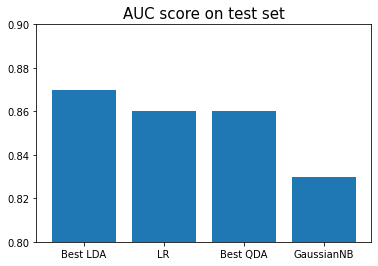

In [17]:
estimators = ["Best LDA", "LR", "Best QDA", "GaussianNB"]
auc_test = [0.87, 0.86, 0.86, 0.83]

plt.bar(estimators, auc_test)
plt.title("AUC score on test set", size=15)
plt.ylim(0.8, 0.9)
plt.show()

With default parameters, Logistic regression performs very well, compared to other fine-tuned models.

In [18]:
lr_l1 = LogisticRegression(penalty='l1', solver="saga")
lr_l1.fit(pima_train_x, pima_train_y)
print(f"The accuracy on test data is {lr_l1.score(pima_test_x, pima_test_y)}")
print(f"The AUC score on test data is {roc_auc_score(pima_test_y, lr_l1.predict_proba(pima_test_x)[:, 1])}")

The accuracy on test data is 0.8019559902200489
The AUC score on test data is 0.8658790066732305


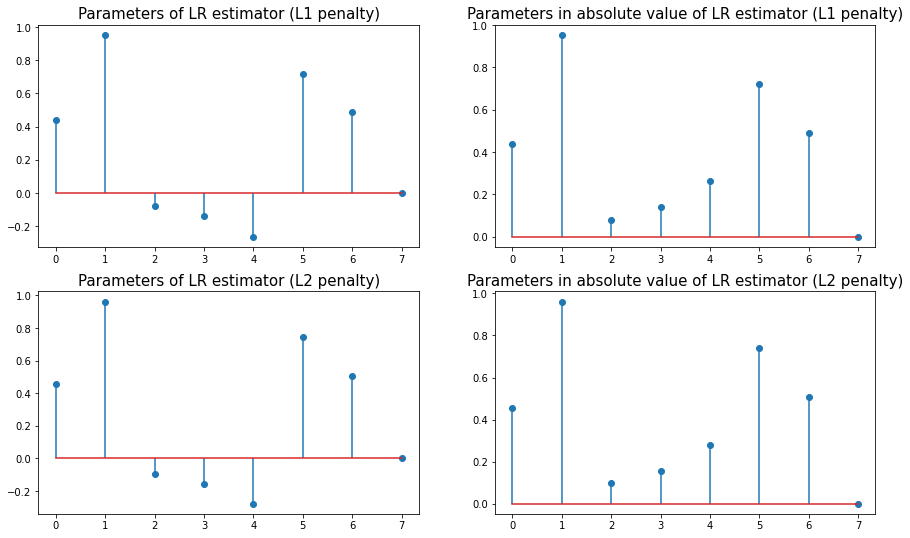

In [19]:
w_reg = lr_l1.coef_.reshape(-1,1)
w_reg_l2 = lr.coef_.reshape(-1,1)

fig, ax = plt.subplots(2, 2, figsize=(15, 9))
ax[0,0].stem(w_reg)
ax[0,0].set_title('Parameters of LR estimator (L1 penalty)', fontsize=15)
ax[0,1].stem(abs(w_reg))
ax[0,1].set_title("Parameters in absolute value of LR estimator (L1 penalty)", fontsize=15)

ax[1,0].stem(w_reg_l2)
ax[1,0].set_title('Parameters of LR estimator (L2 penalty)', fontsize=15)
ax[1,1].stem(abs(w_reg_l2))
ax[1,1].set_title("Parameters in absolute value of LR estimator (L2 penalty)", fontsize=15)
plt.show()

With L1 penalty, the model is sparse, in the sense that the variable `Age` is removed (by setting its parameter $w_i$ to be 0). And we also notice that it is the same case for LR model with L2 penalty. That means the variable `Age`  has no impact on the prediction.

As for the performance, LR model with L1 penalty performs as well as LR model with L2 penalty.


So far, the best model is fine-tuned LDA. On average, the quadratic models perform worse than linear models. 

In [20]:
def hist_predicted_proba(score, model_name):
    plt.figure(figsize=(10, 7))
    plt.title(model_name + " : Histograms of predicted probability for samples", size=20)
    plt.hist(score[:,0], bins=20)
    plt.hist(score[:,1], bins=20)
    plt.xlabel("Predicted probability", size=15)
    plt.ylabel("#samples", size=15)
    plt.show()

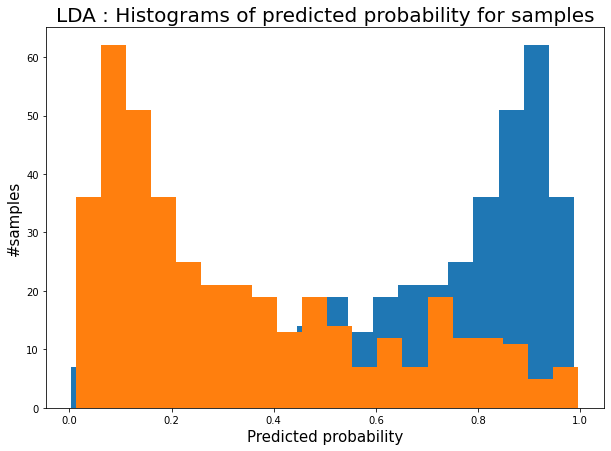

In [21]:
lda = LinearDiscriminantAnalysis(shrinkage=0.41, solver='eigen').fit(pima_train_x, pima_train_y)
score = lda.predict_proba(pima_test_x)
hist_predicted_proba(score, "LDA")

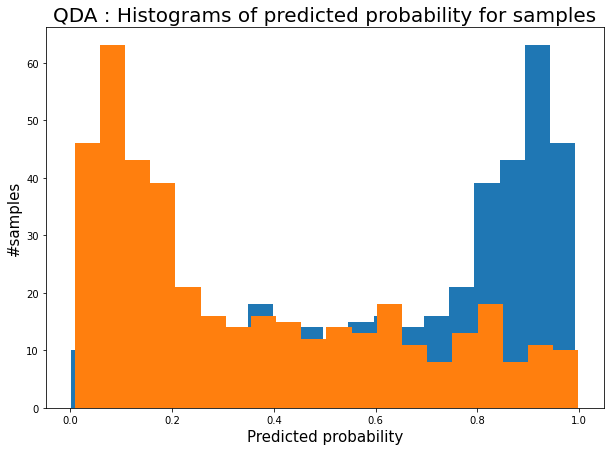

In [22]:
qda = QuadraticDiscriminantAnalysis(reg_param=0.84).fit(pima_train_x, pima_train_y)
score = qda.predict_proba(pima_test_x)
hist_predicted_proba(score, "QDA")

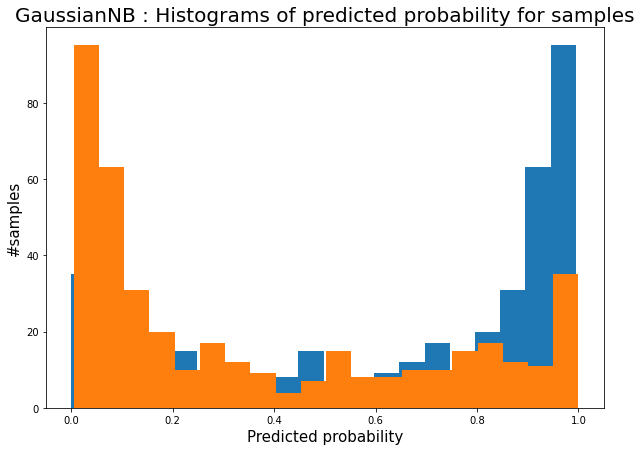

In [23]:
gnb = GaussianNB().fit(pima_train_x, pima_train_y)
score = gnb.predict_proba(pima_test_x)
hist_predicted_proba(score, "GaussianNB")

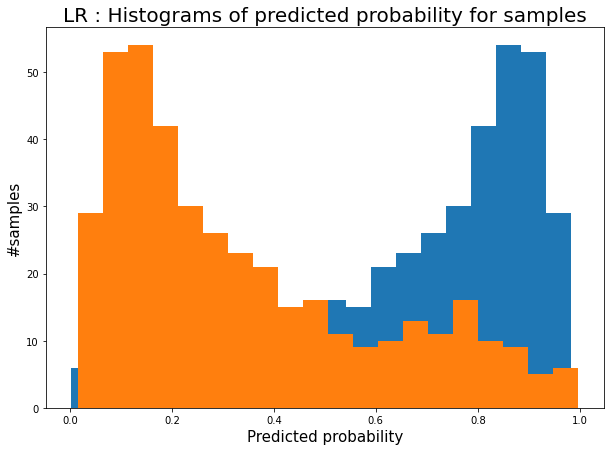

In [24]:
lr = LogisticRegression().fit(pima_train_x, pima_train_y)
score = lr.predict_proba(pima_test_x)
hist_predicted_proba(score, "LR")

Comments:

The distribution of predicted probability represents the separability of samples: if the predicted probability concentrates on the regions nearby 0 or 1, the samples could be easily seperated. Based on this principle, we can compare the models above: GaussianNB provides the best separability; but the separability of LR is relatively the worst, even if it performs well in prediction. 

This means that, for some samples correctedly predicted by LR model, we are not really assured (the predicted probability for two classes are close).

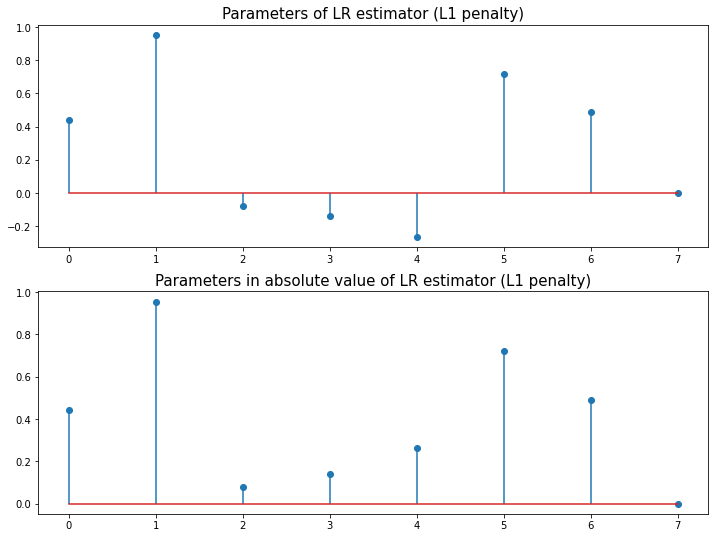

In [25]:
lr_l1 = LogisticRegression(penalty='l1', solver="saga").fit(pima_train_x, pima_train_y)
w_reg = lr_l1.coef_.reshape(-1,1)

fig, ax = plt.subplots(2, 1, figsize=(12, 9))
ax[0].stem(w_reg)
ax[0].set_title('Parameters of LR estimator (L1 penalty)', fontsize=15)
ax[1].stem(abs(w_reg))
ax[1].set_title("Parameters in absolute value of LR estimator (L1 penalty)", fontsize=15)
plt.show()

The weight reflects the importance of corresponding variable, since the standardization has already been performed on dataset. 

We take the LR model with L1 penalty for example. Just as we saw before, the last variable (`Age`) has no impact on Diabetes prediction. The 2nd and 6th one (`Glucose` and `BMI`) are two most important variables, corresponding to our analysis in pairplot. Except these two, it seems that `DiabetesPedigreeFunction` and `Pregnancies` also have non negligible impact on prediction.

I think these variables make medical sense. Intuitively, `Plasma glucose concentration`, `Body mass index` and `Diabetes pedigree function` could really influence the Diabetes.

# Nonlinear methods

### RandomForestClassifier

In [26]:
rfc = RandomForestClassifier()
rfc.fit(pima_train_x, pima_train_y)
print("With default parameters, RandomForestClassifier gives:")
print(f"The accuracy on test data is {rfc.score(pima_test_x, pima_test_y)}")
print(f"The AUC score on test data is {roc_auc_score(pima_test_y, rfc.predict_proba(pima_test_x)[:, 1])}")

With default parameters, RandomForestClassifier gives:
The accuracy on test data is 0.7775061124694377
The AUC score on test data is 0.8563204244612187


### SVC

In [27]:
svc = SVC(probability=True)
svc.fit(pima_train_x, pima_train_y)
print("With default parameters, SVC gives:")
print(f"The accuracy on test data is {svc.score(pima_test_x, pima_test_y)}")
print(f"The AUC score on test data is {roc_auc_score(pima_test_y, svc.predict_proba(pima_test_x)[:, 1])}")

With default parameters, SVC gives:
The accuracy on test data is 0.7872860635696821
The AUC score on test data is 0.8384750027349305


### MLPClassifier

In [28]:
mlp = MLPClassifier()
mlp.fit(pima_train_x, pima_train_y)
print("With default parameters, MLPClassifier gives:")
print(f"The accuracy on test data is {mlp.score(pima_test_x, pima_test_y)}")
print(f"The AUC score on test data is {roc_auc_score(pima_test_y, mlp.predict_proba(pima_test_x)[:, 1])}")

With default parameters, MLPClassifier gives:
The accuracy on test data is 0.7799511002444988
The AUC score on test data is 0.8508642380483536


### GradientBoostingClassifier

In [29]:
gbc = GradientBoostingClassifier()
gbc.fit(pima_train_x, pima_train_y)
print("With default parameters, GradientBoostingClassifier gives:")
print(f"The accuracy on test data is {gbc.score(pima_test_x, pima_test_y)}")
print(f"The AUC score on test data is {roc_auc_score(pima_test_y, gbc.predict_proba(pima_test_x)[:, 1])}")

With default parameters, GradientBoostingClassifier gives:
The accuracy on test data is 0.7579462102689487
The AUC score on test data is 0.8283284104583744


With default parameters, MLPClassifier performs as well as LDA; Others estimators are worse than LDA.

## Model selection

In [30]:
parameters = {'n_estimators': [20, 50, 100, 150, 200, 400, 600, 800]}
grid_search = GridSearchCV(RandomForestClassifier(), parameters, scoring='roc_auc')
grid_search.fit(pima_train_x, pima_train_y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [20, 50, 100, 150, 200, 400, 600,
                                          800]},
             scoring='roc_auc')

In [31]:
print("For RandomForestClassifier:")
print(f"The best parameter is {grid_search.best_params_}, its Mean cross-validated AUC score is {grid_search.best_score_}")
print(f"After refitting the best estimator on whole training set, the AUC score on test set is \
{roc_auc_score(pima_test_y, grid_search.best_estimator_.predict_proba(pima_test_x)[:, 1])}")

For RandomForestClassifier:
The best parameter is {'n_estimators': 100}, its Mean cross-validated AUC score is 0.773803827751196
After refitting the best estimator on whole training set, the AUC score on test set is 0.8463242533639646


For RandomForestClassifier:

 the default parameter is the best. Although it is a random algorithm, the performance is nearly the same as before (both 0.86)

In [32]:
parameters = {'C': np.logspace(-3, 5, 100)}
grid_search = GridSearchCV(SVC(probability=True), parameters, scoring='roc_auc')
grid_search.fit(pima_train_x, pima_train_y)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': array([1.00000000e-03, 1.20450354e-03, 1.45082878e-03, 1.74752840e-03,
       2.10490414e-03, 2.53536449e-03, 3.05385551e-03, 3.67837977e-03,
       4.43062146e-03, 5.33669923e-03, 6.42807312e-03, 7.74263683e-03,
       9.32603347e-03, 1.12332403e-02, 1.35304777e-02, 1.62975083e-02,
       1.96304065e-02, 2.36448941e-02, 2.84803587e-...
       1.38488637e+03, 1.66810054e+03, 2.00923300e+03, 2.42012826e+03,
       2.91505306e+03, 3.51119173e+03, 4.22924287e+03, 5.09413801e+03,
       6.13590727e+03, 7.39072203e+03, 8.90215085e+03, 1.07226722e+04,
       1.29154967e+04, 1.55567614e+04, 1.87381742e+04, 2.25701972e+04,
       2.71858824e+04, 3.27454916e+04, 3.94420606e+04, 4.75081016e+04,
       5.72236766e+04, 6.89261210e+04, 8.30217568e+04, 1.00000000e+05])},
             scoring='roc_auc')

In [33]:
print("For SVC:")
print(f"The best parameter is {grid_search.best_params_}, its Mean cross-validated AUC score is {grid_search.best_score_}")
print(f"After refitting the best estimator on whole training set, the AUC score on test set is \
{roc_auc_score(pima_test_y, grid_search.best_estimator_.predict_proba(pima_test_x)[:, 1])}")

For SVC:
The best parameter is {'C': 0.005336699231206312}, its Mean cross-validated AUC score is 0.7818181818181819
After refitting the best estimator on whole training set, the AUC score on test set is 0.8428508915873537


For SVC: 

The default Regularization parameter `C=1`. With GridSearch, we found that `C=5.33e-03` is the best Regularization parameter, which gives a AUC score `0.843` on test set (compared with the default case `0.838`). 

In [34]:
parameters = {'hidden_layer_sizes': [(20,), (50,), (100,), (200,), (400,), (800,), (1000,)]}
grid_search = GridSearchCV(MLPClassifier(), parameters, scoring='roc_auc')
grid_search.fit(pima_train_x, pima_train_y)

print("For MLPClassifier:")
print(f"The best parameter is {grid_search.best_params_}, its Mean cross-validated AUC score is {grid_search.best_score_}")
print(f"After refitting the best estimator on whole training set, the AUC score on test set is \
{roc_auc_score(pima_test_y, grid_search.best_estimator_.predict_proba(pima_test_x)[:, 1])}")

For MLPClassifier:
The best parameter is {'hidden_layer_sizes': (20,)}, its Mean cross-validated AUC score is 0.795933014354067
After refitting the best estimator on whole training set, the AUC score on test set is 0.8654961163986435


For MLPClassifier: 

The default parameter `hidden_layer_sizes=100`. With GridSearch, we found that `hidden_layer_sizes=20` is the best parameter, which gives a AUC score `0.864` on test set (compared with the default case `0.861`). 

The improve is not evident.

In [35]:
parameters = {'learning_rate': np.logspace(-3, 2, 20), 'n_estimators': [10, 20, 50, 70, 100, 150, 300, 500]}
grid_search = GridSearchCV(GradientBoostingClassifier(), parameters, scoring='roc_auc')
grid_search.fit(pima_train_x, pima_train_y)

print("For GradientBoostingClassifier:")
print(f"The best parameter is {grid_search.best_params_}, its Mean cross-validated AUC score is {grid_search.best_score_}")
print(f"After refitting the best estimator on whole training set, the AUC score on test set is \
{roc_auc_score(pima_test_y, grid_search.best_estimator_.predict_proba(pima_test_x)[:, 1])}")

For GradientBoostingClassifier:
The best parameter is {'learning_rate': 0.12742749857031335, 'n_estimators': 20}, its Mean cross-validated AUC score is 0.7721291866028708
After refitting the best estimator on whole training set, the AUC score on test set is 0.8345640520730775


For GradientBoostingClassifier: 

The default parameter `learning_rate=0.1`, `n_estimators=100`. With GridSearch, we found that `learning_rate=0.038`, `n_estimators=70` is the best parameter, which gives a AUC score `0.841` on test set (compared with the default case `0.827`).

The improve is evident.

# Comparison and interpretation

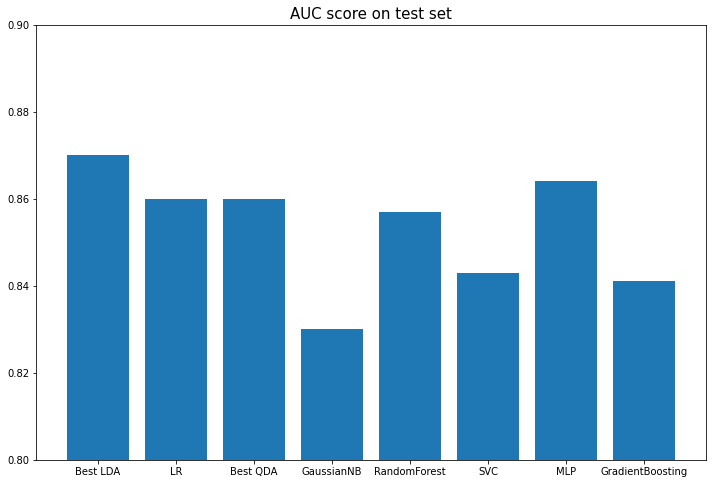

In [36]:
estimators = ["Best LDA", "LR", "Best QDA", "GaussianNB", "RandomForest", "SVC", "MLP", "GradientBoosting"]
auc_test = [0.87, 0.86, 0.86, 0.83, 0.857, 0.843, 0.864, 0.841]

plt.figure(figsize=(12, 8))
plt.bar(estimators, auc_test)
plt.title("AUC score on test set", size=15)
plt.ylim(0.8, 0.9)
plt.show()

Overall methods investigated above, the best is LDA. 

From a medical perspective, a linear model (LDA) is more appropriate and more interpretable. Because we want to analyse which factors really influence the diabetes. Considering the performance, the non-linearity is not necessary.

In [37]:
parameters = {'shrinkage': np.linspace(0, 1, 50)}
grid_search_LDA = GridSearchCV(LinearDiscriminantAnalysis(solver='eigen'), parameters, scoring='roc_auc')
grid_search_LDA.fit(pima_train_x, pima_train_y)

GridSearchCV(estimator=LinearDiscriminantAnalysis(solver='eigen'),
             param_grid={'shrinkage': array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])},
             scoring='roc_auc')

In [46]:
threshold = 0.5
predict_LDA = 2*(grid_search_LDA.best_estimator_.predict_proba(pima_test_x)[:, 1] > threshold) - 1
confusion_matrix(pima_test_y, predict_LDA, labels=[-1, 1])

array([[251,  26],
       [ 51,  81]], dtype=int64)

The confusion matrix is printed above. `FNR=FN/(FN+TP)`. Given that the i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class, we got `FN=51, TP=81`, therefore `FNR=38.6%`.

The FNR is too high. There would be many patients (who indeed have diabetes) considered as non-patients. Nearly 39% diabetes patients would be misguided. 

In [50]:
thresholds = [0.23, 0.25, 0.3, 0.4, 0.5]
for threshold in thresholds:
    predict_LDA = 2*(grid_search_LDA.best_estimator_.predict_proba(pima_test_x)[:, 1] > threshold) - 1
    C = confusion_matrix(pima_test_y, predict_LDA, labels=[-1, 1])
    FNR = C[1][0] / (C[1][0] + C[1][1])
    print(f"When threshold = {threshold}, FNR={FNR}.")

When threshold = 0.23, FNR=0.09848484848484848.
When threshold = 0.25, FNR=0.11363636363636363.
When threshold = 0.3, FNR=0.19696969696969696.
When threshold = 0.4, FNR=0.30303030303030304.
When threshold = 0.5, FNR=0.38636363636363635.


For a `threshold=0.23`, we obtain a FNR less than 10%. That is to say, if the predicted probability of being positive is bigger than 0.23, we will consider the sample as positive.

# Predicting Classes on the Digits dataset

###  Evaluate the different supervised methods

In [54]:
lda = LinearDiscriminantAnalysis()
lda.fit(img_train, img_train_label)

print(f"For LDA, The accuracy on test data is {lda.score(img, img_label)}")
# print(f"The AUC score on test data is {roc_auc_score(pima_test_y, lda.predict_proba(pima_test_x)[:, 1])}")

For LDA, The accuracy on test data is 0.897


In [55]:
lr = LogisticRegression()
lr.fit(img_train, img_train_label)
print(f"For LR, The accuracy on test data is {lr.score(img, img_label)}")

For LR, The accuracy on test data is 0.9713333333333334


In [60]:
svc = SVC(probability=True)
svc.fit(img_train, img_train_label)
print(f"For SVC, The accuracy on test data is {svc.score(img, img_label)}")

For SVC, The accuracy on test data is 0.986


In [59]:
mlp = MLPClassifier()
mlp.fit(img_train, img_train_label)
print(f"For MLP, The accuracy on test data is {mlp.score(img, img_label)}")

For MLP, The accuracy on test data is 0.9803333333333333


In [64]:
parameters = {'C': np.logspace(-3, 5, 20)}
grid_search = GridSearchCV(SVC(probability=True), parameters, scoring='accuracy')
grid_search.fit(img_train, img_train_label)
print("For SVC:")
print(f"The best parameter is {grid_search.best_params_}")
print(f"After refitting the best estimator on whole training set, the accuracy on test set is {grid_search.best_estimator_.score(img, img_label)}")

For SVC:
The best parameter is {'C': 0.8858667904100823}
After refitting the best estimator on whole training set, the accuracy on test set is 0.986


In [65]:
parameters = {'hidden_layer_sizes': [(20,), (50,), (100,), (200,), (400,), (800,), (1000,)]}
grid_search = GridSearchCV(MLPClassifier(), parameters, scoring='accuracy')
grid_search.fit(img_train, img_train_label)
print("For MLPClassifier:")
print(f"The best parameter is {grid_search.best_params_}")
print(f"After refitting the best estimator on whole training set, the accuracy on test set is {grid_search.best_estimator_.score(img, img_label)}")

For MLPClassifier:
The best parameter is {'hidden_layer_sizes': (1000,)}
After refitting the best estimator on whole training set, the accuracy on test set is 0.9826666666666667


In [67]:
parameters = {'shrinkage': np.linspace(0, 1, 20)}
grid_search = GridSearchCV(LinearDiscriminantAnalysis(solver='eigen'), parameters, scoring='accuracy')
grid_search.fit(img_train, img_train_label)
print("For LDA:")
print(f"The best parameter is {grid_search.best_params_}")
print(f"After refitting the best estimator on whole training set, the accuracy on test set is {grid_search.best_estimator_.score(img, img_label)}")

For LDA:
The best parameter is {'shrinkage': 0.3157894736842105}
After refitting the best estimator on whole training set, the accuracy on test set is 0.9576666666666667


The best model (with highest accuracy) is SVC, with `C=0.886`. It gives the accuracy `0.986` on test set.

In [70]:
svc_best = SVC(probability=True, C=0.886)
svc_best.fit(img_train, img_train_label)
print(f"For best model (SVC), The accuracy on test data is {svc_best.score(img, img_label)}")

For best model (SVC), The accuracy on test data is 0.986


### Interpreting the classifier

We first train the models with best selected parameters. Then we compare them with different metrics, including `confusion matrix, AUC, balanced_accuracy, f1 score (micro and macro)`.

In [72]:
mlp_best = MLPClassifier(hidden_layer_sizes=(1000,))
mlp_best.fit(img_train, img_train_label)

MLPClassifier(hidden_layer_sizes=(1000,))

In [74]:
lda_best = LinearDiscriminantAnalysis(shrinkage=0.316, solver='eigen')
lda_best.fit(img_train, img_train_label)

LinearDiscriminantAnalysis(shrinkage=0.316, solver='eigen')

In [79]:
img_label.shape

(3000, 1)

In [81]:
est = lda_best
print("For LDA:")
print("Confusion matrix is:")
print(confusion_matrix(img_label, est.predict(img)))
print(f"AUC is {roc_auc_score(img_label.reshape(-1,), est.predict_proba(img), average = 'macro', multi_class='ovo')}")
print(f"Balanced accuracy is {balanced_accuracy_score(img_label, est.predict(img))}")
print(f"F1 score macro is {f1_score(img_label, est.predict(img), average='macro')}")

For LDA:
Confusion matrix is:
[[977   5  18]
 [ 12 984   4]
 [ 61  27 912]]
AUC is 0.995
Balanced accuracy is 0.9576666666666666
F1 score macro is 0.9574947563037456


In [82]:
est = mlp_best
print("For MLP:")
print("Confusion matrix is:")
print(confusion_matrix(img_label, est.predict(img)))
print(f"AUC is {roc_auc_score(img_label.reshape(-1,), est.predict_proba(img), average = 'macro', multi_class='ovo')}")
print(f"Balanced accuracy is {balanced_accuracy_score(img_label, est.predict(img))}")
print(f"F1 score macro is {f1_score(img_label, est.predict(img), average='macro')}")

For MLP:
Confusion matrix is:
[[986   4  10]
 [  3 994   3]
 [ 13  19 968]]
AUC is 0.9985885
Balanced accuracy is 0.9826666666666667
F1 score macro is 0.9826404653729285


In [83]:
est = svc_best
print("For SVC:")
print("Confusion matrix is:")
print(confusion_matrix(img_label, est.predict(img)))
print(f"AUC is {roc_auc_score(img_label.reshape(-1,), est.predict_proba(img), average = 'macro', multi_class='ovo')}")
print(f"Balanced accuracy is {balanced_accuracy_score(img_label, est.predict(img))}")
print(f"F1 score macro is {f1_score(img_label, est.predict(img), average='macro')}")

For SVC:
Confusion matrix is:
[[982   4  14]
 [  2 994   4]
 [  9   9 982]]
AUC is 0.9992333333333333
Balanced accuracy is 0.9860000000000001
F1 score macro is 0.9859940685940071


The SVC is the best classifier w.r.t different metrics. Its confusion matrix is printed above. 

The class `1, 8` are harder to discriminate. Compared to class `7`, there are more misclassified samples in these two classes.

In [87]:
ind_misclassified =[i for i, bool_ in enumerate(img_label.reshape(-1,) == svc_best.predict(img)) if not bool_]

In [91]:
print(len(ind_misclassified))

42


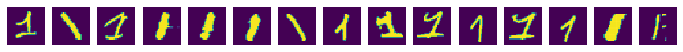

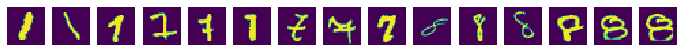

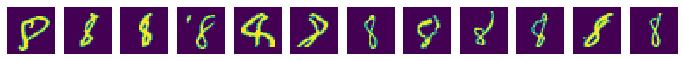

In [92]:
plots(img.reshape(3000, 28 ,28)[ind_misclassified[:15],:,:])
plots(img.reshape(3000, 28 ,28)[ind_misclassified[15:30],:,:])
plots(img.reshape(3000, 28 ,28)[ind_misclassified[30:],:,:])

These are all misclassified samples. Even for human, it is really difficult to recognize them. Some of them looks like another digits (e.g. `1` looks like `7`), some of them are not clear (e.g. some samples `8` are not complet.)

In [95]:
ind_wellclassified = set(range(3000)) - set(ind_misclassified)

In [243]:
ind = next(iter(ind_wellclassified))

After add noise of level 0.1, the balanced accuracy is 1.0


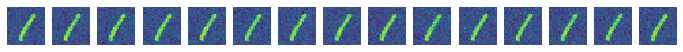

In [111]:
noisy_std = 0.1
noisy_samples = img[ind] + np.random.randn(1000, 784) * noisy_std
plots(noisy_samples.reshape(-1, 28 ,28)[:15,:,:])
print(f"After add noise of level {noisy_std}, the balanced accuracy is {balanced_accuracy_score([1]*1000, svc_best.predict(noisy_samples))}")

After add noise of level 0.2, the balanced accuracy is 1.0


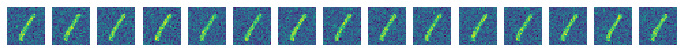

In [113]:
noisy_std = 0.2
noisy_samples = img[ind] + np.random.randn(1000, 784) * noisy_std
plots(noisy_samples.reshape(-1, 28 ,28)[:15,:,:])
print(f"After add noise of level {noisy_std}, the balanced accuracy is {balanced_accuracy_score([1]*1000, svc_best.predict(noisy_samples))}")

After add noise of level 0.3, the balanced accuracy is 0.096


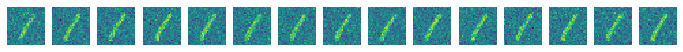

In [114]:
noisy_std = 0.3
noisy_samples = img[ind] + np.random.randn(1000, 784) * noisy_std
plots(noisy_samples.reshape(-1, 28 ,28)[:15,:,:])
print(f"After add noise of level {noisy_std}, the balanced accuracy is {balanced_accuracy_score([1]*1000, svc_best.predict(noisy_samples))}")

The accuracy is no longer 1. It decreased rapidly to 9.6%. We will then choose a noise level more fine, between 0.2 and 0.3. 

After add noise of level 0.22, the balanced accuracy is 1.0


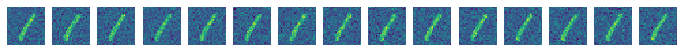

In [116]:
noisy_std = 0.22
noisy_samples = img[ind] + np.random.randn(1000, 784) * noisy_std
plots(noisy_samples.reshape(-1, 28 ,28)[:15,:,:])
print(f"After add noise of level {noisy_std}, the balanced accuracy is {balanced_accuracy_score([1]*1000, svc_best.predict(noisy_samples))}")

After add noise of level 0.23, the balanced accuracy is 0.998


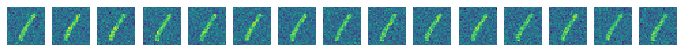

In [117]:
noisy_std = 0.23
noisy_samples = img[ind] + np.random.randn(1000, 784) * noisy_std
plots(noisy_samples.reshape(-1, 28 ,28)[:15,:,:])
print(f"After add noise of level {noisy_std}, the balanced accuracy is {balanced_accuracy_score([1]*1000, svc_best.predict(noisy_samples))}")

The model is robust w.r.t a gaussian noise (zero-mean, standard error equals to 0.22). When the standard error continue to increase, the model begins to degenerate. 

There are some adversarial examples above. We can still distinguish the digits, but the model can not.

# Bonus: Convolutional Neural network (CNN)

In [161]:
import torch
import torch.nn as nn
from sklearn import preprocessing

In [233]:
le = preprocessing.LabelEncoder()
img_train_label = le.fit_transform(img_train_label)
img_label = le.transform(img_label)
# img_train_label = torch.squeeze(torch.Tensor(img_train_label))
# img_label = torch.squeeze(torch.Tensor(img_label))

img = torch.tensor(img.reshape(3000, 1, 28 ,28), dtype=torch.float32)
img_train = torch.tensor(img_train.reshape(1500, 1, 28 ,28), dtype=torch.float32)
img_train_loader = torch.utils.data.DataLoader([[img_train[i], img_train_label[i]] for i in range(img_train_label.shape[0])],
                                     batch_size=32, shuffle=True)

In [234]:
learning_rate = 0.01
n_epochs = 5

nb_classes = 3
# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = 1 # greyscale input images
n_h_1 = nb_filters
n_h_2 = nb_filters

In [235]:
digits_model = torch.nn.Sequential(
    nn.Conv2d(in_channels=n_h_0, out_channels=n_h_1, kernel_size=kernel_size, padding='same'),
    nn.ReLU(),
    nn.Conv2d(in_channels=n_h_1, out_channels=n_h_2, kernel_size=kernel_size, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=pool_size, stride = pool_size),
    nn.Flatten(),
    nn.Linear(in_features=14*14*n_h_2, out_features=nb_classes),
)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(digits_model.parameters(), lr=learning_rate)

In [236]:
def vector_to_class(x):
  y = nn.Softmax(dim=1)(x)
  y = torch.argmax(y, axis=1)
  return y

def cnn_accuracy(predict, labels):
  accuracy = (predict == labels).sum() / labels.shape[0]
  return accuracy

In [237]:
train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs):
  train_loss=0.0

  for batch_idx, (imgs_, labels) in enumerate(img_train_loader):
    optimizer.zero_grad()
    predict = digits_model(imgs_)
    # apply loss function
    loss=criterion(predict, labels)
    # backpropagation
    loss.backward()
    optimizer.step()
    train_loss=loss.item()
  print('Epoch:{} Train Loss:{:.4f}'.format(epoch, train_loss/imgs_.shape[0]))
  # calculate accuracy
  print('Accuracy:{:.4f}'.format(cnn_accuracy(vector_to_class(predict), labels)))

Epoch:0 Train Loss:0.0040
Accuracy:0.9643
Epoch:1 Train Loss:0.0002
Accuracy:1.0000
Epoch:2 Train Loss:0.0000
Accuracy:1.0000
Epoch:3 Train Loss:0.0025
Accuracy:0.9643
Epoch:4 Train Loss:0.0001
Accuracy:1.0000


In [240]:
predict_train = digits_model(img_train)
predict_test = digits_model(img)

train_accuracy = cnn_accuracy(vector_to_class(predict_train), torch.Tensor(img_train_label))
test_accuracy = cnn_accuracy(vector_to_class(predict_test), torch.Tensor(img_label))
print("Train Accuracy:", train_accuracy.item())
print("Test Accuracy:", test_accuracy.item())

Train Accuracy: 0.9986666440963745
Test Accuracy: 0.9753333330154419


In [241]:
predict_noise = digits_model(torch.tensor(noisy_samples.reshape(1000, 1, 28 ,28), dtype=torch.float32))
accuracy_noise = cnn_accuracy(vector_to_class(predict_noise), torch.Tensor([0]*1000))

In [242]:
print("Accuracy on noisy samples:", accuracy_noise.item())

Accuracy on noisy samples: 0.9940000176429749


For this architecture of CNN, it does not have a better performance than SVC. Moreover, the robustness is not as good as SVC.

# Comments:

The first point I've learned is how to `analyse the pairplot`. If for one variable, the distributions in different classes are distinctable, this variable is discriminatory.

The second point focuses on the `best_score_ of Grid search`. The default cross-validation strategy is 5-fold. The real training data for each cross-validated model is 4/5 amount of total training data. And the rest 1/5 data is left for computing validation score. **Attention**: That's why the mean cross-validated score is different from (usually lower than) the final score (taking refitted best estimator, test it on test set).

Another point is that, the False negative rate is important in some context. For medical application, we prefer to declare more positive cases than to have FNR too high. 

In the end, I'm suprised by the fact that SVC is so performant on digits dataset, even better than a simple CNN.  

In [247]:
!jupyter nbconvert --to html ML_TP3.ipynb

[NbConvertApp] Converting notebook ML_TP3.ipynb to html
[NbConvertApp] Writing 2217126 bytes to ML_TP3.html
